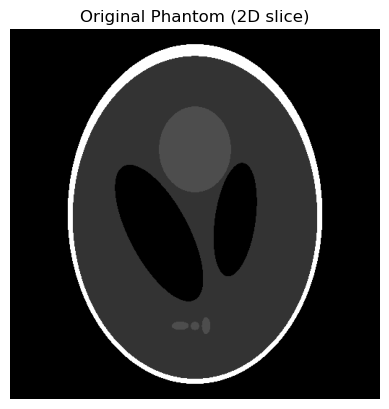

/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


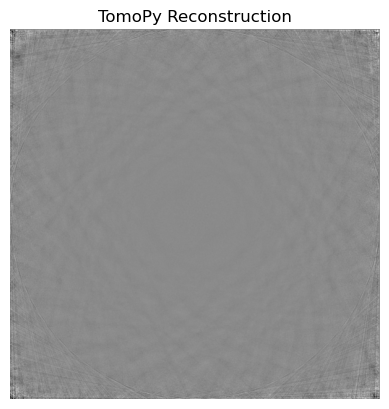

In [7]:
import numpy as np
import tomopy
import matplotlib.pyplot as plt
from skimage.transform import radon

# === 1. Generate a 2D phantom image ===
phantom = tomopy.shepp2d()        # shape: (1, 512, 512)
phantom_2d = phantom[0]           # shape: (512, 512)

# === 2. Display the image ===
plt.imshow(phantom_2d, cmap='gray')
plt.title("Original Phantom (2D slice)")
plt.axis('off')
plt.show()

# === 3. Simulate sinogram ===
theta = np.linspace(0., 180., max(phantom_2d.shape), endpoint=False)
sinogram = radon(phantom_2d, theta=theta, circle=True)

# === 4. Format for TomoPy ===
proj = sinogram[:, np.newaxis, :].astype(np.float32)  # (angles, 1, detector pixels)

# === 5. Reconstruct ===
rec = tomopy.recon(proj, theta, algorithm='gridrec')  # shape: (1, H, W)

# === 6. Show reconstructed image ===
plt.imshow(rec[0], cmap='gray')
plt.title("TomoPy Reconstruction")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import tifffile
import tomopy
import matplotlib.pyplot as plt

# === Step 1: Load TIFF stack ===
file_path = "recon_025_AS1.6_4DPF_WB_18x(361nm).tiff"
sinogram_stack = tifffile.imread(file_path).astype(np.float32)
print("📂 TIFF loaded with shape:", sinogram_stack.shape)
print("Shape of loaded TIFF stack:", stack.shape)

# === Step 2: Flagged bad bins (manually + PCA combined) ===
bad_bins = np.array([
    909, 910, 911, 912, 913, 914, 915, 916, 917, 918,
    923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
    937, 938, 939, 940, 941, 942, 943, 944, 945, 946,
    1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074,
    1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084,
    1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094,
    1095, 1096, 1097, 1098
])

# === Step 3: Interpolate bad bins ===
for b in bad_bins:
    if 2 < b < sinogram_stack.shape[1] - 3:
        sinogram_stack[:, b] = (
            0.25 * sinogram_stack[:, b - 2] +
            0.5  * sinogram_stack[:, b - 1] +
            0.5  * sinogram_stack[:, b + 1] +
            0.25 * sinogram_stack[:, b + 2]
        ) / 1.5

print(f"🧼 Interpolated {len(bad_bins)} flagged detector bins.")

# === Step 4: Format for TomoPy ===
proj = sinogram_stack[:, np.newaxis, :]  # (angles, 1, pixels)

# === Step 5: Apply Wavelet-Fourier stripe removal ===
proj_clean = tomopy.remove_stripe_fw(proj, level=5, wname='sym16', sigma=1, pad=True)
print("🌀 Wavelet-Fourier ring suppression applied.")

# === Step 6: Generate theta angles ===
theta = np.linspace(0., 180., proj.shape[0], endpoint=False)

# === Step 7: Reconstruct using TomoPy ===
recon = tomopy.recon(proj_clean, theta, algorithm='gridrec')
print("✅ TomoPy reconstruction complete.")

# === Step 8: Show result ===
plt.imshow(recon[0], cmap='gray')
plt.title("Reconstructed Slice (Corrected)")
plt.axis('off')
plt.show()


In [1]:
import tifffile
stack = tifffile.imread("recon_025_AS1.6_4DPF_WB_18x(361nm).tiff")
print(stack.shape)


(2160, 1855, 1719)


📂 Stack shape: (2160, 1855, 1719)


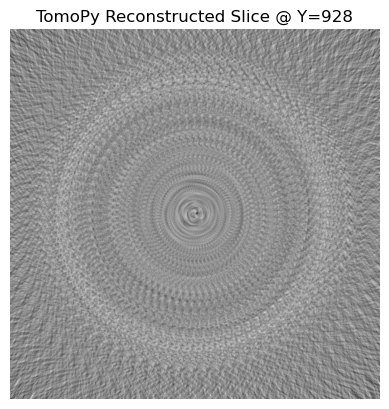

In [2]:
import numpy as np
import tifffile
import tomopy
import matplotlib.pyplot as plt

# === Step 1: Load raw sinogram stack ===
file_path = "recon_025_AS1.6_4DPF_WB_18x(361nm).tiff"
stack = tifffile.imread(file_path).astype(np.float32)
print("📂 Stack shape:", stack.shape)  # (2160, 1855, 1719)

# === Step 2: Choose a single slice (e.g., vertical index 928 = center) ===
target_index = 928  # midpoint of 1855
sinogram = stack[:, target_index, :]  # shape: (2160, 1719)

# === Step 3: Interpolate flagged bins ===
bad_bins = np.array([
    909, 910, 911, 912, 913, 914, 915, 916, 917, 918,
    923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
    937, 938, 939, 940, 941, 942, 943, 944, 945, 946,
    1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074,
    1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084,
    1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094,
    1095, 1096, 1097, 1098
])

for b in bad_bins:
    if 2 < b < sinogram.shape[1] - 3:
        sinogram[:, b] = (
            0.25 * sinogram[:, b - 2] +
            0.5  * sinogram[:, b - 1] +
            0.5  * sinogram[:, b + 1] +
            0.25 * sinogram[:, b + 2]
        ) / 1.5

# === Step 4: Format to TomoPy shape ===
proj = sinogram[:, np.newaxis, :]  # shape: (2160, 1, 1719)

# === Step 5: Clean with Wavelet-Fourier ===
proj_clean = tomopy.remove_stripe_fw(proj, level=5, wname='sym16', sigma=1, pad=True)

# === Step 6: Define angles ===
theta = np.linspace(0., 180., proj.shape[0], endpoint=False)

# === Step 7: Reconstruct ===
recon = tomopy.recon(proj_clean, theta, algorithm='gridrec')

# === Step 8: Visualize ===
plt.imshow(recon[0], cmap='gray')
plt.title(f"TomoPy Reconstructed Slice @ Y={target_index}")
plt.axis('off')
plt.show()


In [4]:
stack = tifffile.imread("recon_025_AS1.6_4DPF_WB_18x(361nm).tiff").astype(np.float32)

/tmp/ipykernel_2516/889454517.py:57: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2516/889454517.py:57: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2516/889454517.py:57: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CH

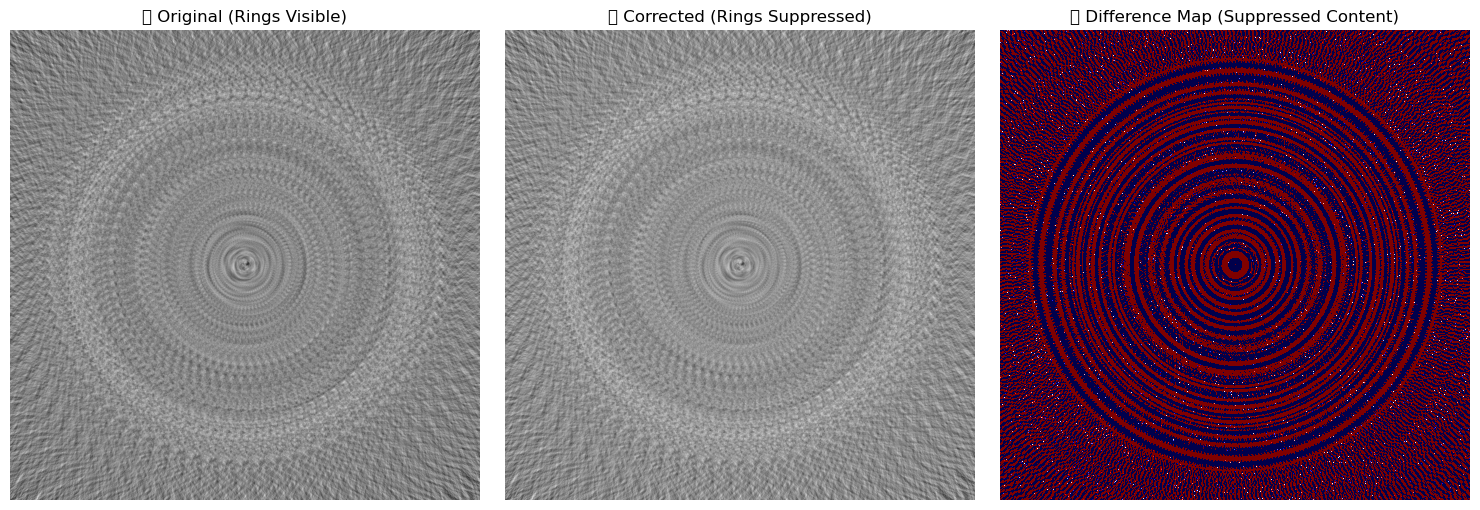

In [5]:
import numpy as np
import tomopy
import matplotlib.pyplot as plt

# === 1. Choose middle slice ===
y = 928
original = stack[:, y, :].copy()

# === 2. Clean copy ===
clean = original.copy()

# === 3. Flagged bad bins (combined list) ===
bad_bins = np.array([
    909, 910, 911, 912, 913, 914, 915, 916, 917, 918,
    923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
    937, 938, 939, 940, 941, 942, 943, 944, 945, 946,
    1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074,
    1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084,
    1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094,
    1095, 1096, 1097, 1098
])

# === 4. Interpolate bad bins ===
for b in bad_bins:
    if 2 < b < clean.shape[1] - 3:
        clean[:, b] = (
            0.25 * clean[:, b - 2] +
            0.5  * clean[:, b - 1] +
            0.5  * clean[:, b + 1] +
            0.25 * clean[:, b + 2]
        ) / 1.5

# === 5. Format and suppress rings ===
proj_original = original[:, np.newaxis, :]
proj_cleaned = tomopy.remove_stripe_fw(clean[:, np.newaxis, :], level=5, wname='sym16', sigma=1)

# === 6. Theta & Reconstruction ===
theta = np.linspace(0., 180., proj_original.shape[0], endpoint=False)
rec_orig = tomopy.recon(proj_original, theta, algorithm='gridrec')[0]
rec_clean = tomopy.recon(proj_cleaned, theta, algorithm='gridrec')[0]

# === 7. Plot side-by-side ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rec_orig, cmap='gray')
axes[0].set_title("❌ Original (Rings Visible)")
axes[0].axis('off')

axes[1].imshow(rec_clean, cmap='gray')
axes[1].set_title("✅ Corrected (Rings Suppressed)")
axes[1].axis('off')

diff = rec_orig - rec_clean
axes[2].imshow(diff, cmap='seismic', vmin=-0.1, vmax=0.1)
axes[2].set_title("📉 Difference Map (Suppressed Content)")
axes[2].axis('off')

plt.tight_layout()
plt.show()
